# E02 Frequency-based audio analysis

### Gianluca Scuri 886725

Implement three distinct feature extractors based respectively on Spectrogram, Mel Spectrogram, and MFCC. Consider a single-channel audio signal, and start from the commands shown during the laboratory.

1. Show the effects on classification performance for the dataset "free-spoken-digit-dataset" (recordings.tar).
2. No feature combination is required for this assignment.
3. You can (and should!) use Librosa for the audio description.

In [1]:
# Import packages
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd # Notebook only

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

In [2]:
drive.mount('/content/gdrive')
tar = tarfile.open('gdrive/MyDrive/Colab Notebooks/Digital Signal/Datasets/recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Example

In [3]:
[sound_rate, sound_data] = wav.read('recordings/0_jackson_0.wav')
print(sound_rate)
print(sound_data.shape)

8000
(5148,)


In [4]:
ipd.Audio(sound_data, rate=sound_rate)

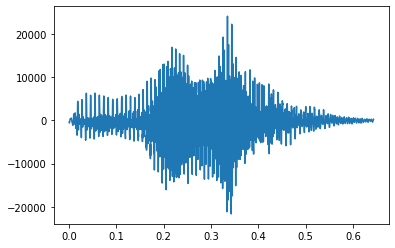

In [5]:
sound_time = np.arange(sound_data.shape[0])*1.0/sound_rate
plt.plot(sound_time, sound_data)

## Data loader

In [6]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

## SVM con Spectrogram

### Feature extractor

In [7]:
def feats_spectrogram(input, rate=8000, tsize=10):
  _, _, spec = spectrogram(input, fs=rate)
  output = spec[:, 0:min(spec.shape[1], tsize)]
  output = np.pad(output, ((0, 0), (0, tsize-output.shape[1])))
  output_flatten = output.flatten()
  return output_flatten

Funzione per il calcolo dello spettrogramma

1. calcolo della matrice 2d dello spettrogramma con la funzione spectrogram() di scipy
2. limitazione sul numero delle colonne (intervalli temporali) ad essere inferiore a tsize=10
3. zero-padding delle matrici con numero di colonne inferiore a tsize=10 con la funzione pad() di numpy
4. unroll della matrice in un array 1d con la funzione flatten() di numpy

### Fitting

In [8]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_spectrogram, normalize=True)

In [9]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 37.287s


In [10]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.005


In [11]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.58      0.70      0.64        10
           2       0.77      0.67      0.71        15
           3       0.65      0.58      0.61        19
           4       0.30      0.27      0.29        11
           5       0.75      0.64      0.69        14
           6       0.18      0.64      0.28        14
           7       0.67      0.32      0.43        19
           8       0.80      0.24      0.36        17
           9       0.67      0.43      0.52        14

    accuracy                           0.50       150
   macro avg       0.62      0.51      0.52       150
weighted avg       0.64      0.50      0.53       150



Confusion matrix:


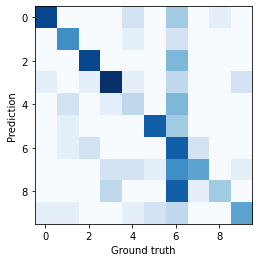

In [12]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

Il risultato é un modello con una accuratezza del 50%. La matrice di confusione presenta una diagonale abbastanza definita

## SVM con Mel Spectrogram

### Feature extractor

In [13]:
def feats_mel(input, rate=8000, tsize=10):
  mel = melspectrogram(y=input*1.0, sr=rate)
  output = mel[:, 0:min(mel.shape[1], tsize)]
  output = np.pad(output, ((0, 0), (0, tsize-output.shape[1])))
  output_flatten = output.flatten()
  return output_flatten

Funzione per il calcolo dello spettrogramma mel

1. calcolo della matrice 2d dello spettrogramma mel con la funzione melspectrogram() di librosa
2. limitazione sul numero delle colonne (intervalli temporali) ad essere inferiore a tsize=10
3. zero-padding delle matrici con numero di colonne inferiore a tsize=10 con la funzione pad() di numpy
4. unroll della matrice in un array 1d con la funzione flatten() di numpy

### Fitting

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mel, normalize=True);

In [15]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 23.180s


In [16]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.005


In [17]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.94      0.44        17
           1       0.67      0.60      0.63        10
           2       0.64      0.60      0.62        15
           3       0.80      0.63      0.71        19
           4       0.44      0.36      0.40        11
           5       0.71      0.71      0.71        14
           6       0.62      0.36      0.45        14
           7       0.83      0.53      0.65        19
           8       0.78      0.41      0.54        17
           9       0.80      0.29      0.42        14

    accuracy                           0.55       150
   macro avg       0.66      0.54      0.56       150
weighted avg       0.67      0.55      0.56       150



Confusion matrix:


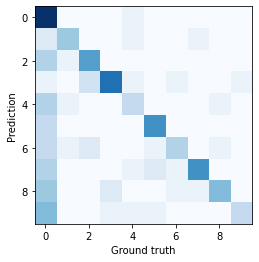

In [18]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

L'utilizzo del Mel Spectrogram ha portato l'accuratezza al 55%. La matrice di confusione presenta una diagonale abbastanza definita, si nota come la maggior parte delle predizioni sono per la classe '0'.

## SVM con MFCC

### Feature extractor

In [19]:
def feats_mfcc(input, rate=8000, tsize=10):
  mfccs = mfcc(input*1.0, sr=rate)
  output = mfccs[:, 0:min(mfccs.shape[1], tsize)]
  output = np.pad(output, ((0, 0), (0, tsize-output.shape[1])))
  output_flatten = output.flatten()
  return output_flatten

Funzione per il calcolo del Mel Frequency Cepstral Coefficient MFCC

1. calcolo della matrice 2d del MFCC con la funzione mfcc() di librosa
2. limitazione sul numero delle colonne (intervalli temporali) ad essere inferiore a tsize=10
3. zero-padding delle matrici con numero di colonne inferiore a tsize=10 con la funzione pad() di numpy
4. unroll della matrice in un array 1d con la funzione flatten() di numpy

### Fitting

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, normalize=True);

In [21]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 6.213s


In [22]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.005


In [23]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        17
           9       0.93      1.00      0.97        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Confusion matrix:


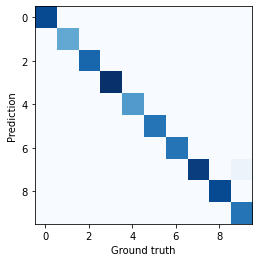

In [24]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');

L'utilizzo del MFCC ha permesso all'accuratezza di raggiungere il 99% e presenta una matrice di confusione con una diagonale estremamente definita. Questi risultati sono peró distorti poiché nel train set e nel test set sono presenti registrazioni provenienti dalla stessa persona.